In [7]:
import numpy as np
from torch import nn
import torch
import random
from torch.distributions import Categorical

from collections import deque

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
class My_env:
    def __init__(self):
        self.state = torch.tensor(data = [0, 0, 0, 0], dtype = torch.float32)
        self.action_0_reward = 5
        self.action_1_reward = 20
        self.action_2_reward = 0

        self.minus_pt_prob = 0.1

        self.step_counter = 0
        self.max_step = 10
        self.max_score = self.max_step * max(self.action_0_reward, self.action_1_reward, self.action_2_reward)

    def reset(self):
        # Reset môi trường trở về trạng thái ban đầu và trả về quan sát đầu tiên
        self.state = torch.tensor(data = [0, 0, 0, 0], dtype = torch.float32)
        self.step_counter = 0
        return self.state
    
    def step(self, action):
        self.step_counter += 1
        self.state[action + 1] += 1

        if action == 0: # action A -> +5 points
            self.state[0] += self.action_0_reward
            reward = self.action_0_reward
        elif action == 1: # action B -> +20 pts with probs = 0.9, -all otherwise
            tmp = random.uniform(0, 1)
            if tmp <= 0.1: 
                reward = -20 #-self.state[0]
                self.state[0] = 0
            else: 
                self.state[0] += self.action_1_reward
                reward = self.action_1_reward
        elif action == 2: # action C -> +0 pts
            self.state[0] += self.action_2_reward
            reward = self.action_2_reward

        done = False
        if self.step_counter == self.max_step:
            done = True
        return self.state, reward, done

In [9]:
class My_policy(nn.Module):
    def __init__(self, env, n_hiddens = 5):
        super().__init__()
        self.env = env
        self.fc1 = nn.Linear(4, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, 3)

    def normalize(self, state):
        state[0] /= self.env.max_score
        state[1] /= self.env.max_step
        state[2] /= self.env.max_step
        state[3] /= self.env.max_step
        return state
    
    def forward(self, state): # state: 
        state = self.normalize(state).to(device)
        h = self.fc1(state)
        output = self.fc2(h)
        return torch.softmax(output, dim = 0)

    def act(self, state):
        state = state.float().to(device)
        probs = self.forward(state).cpu()
        # [0, 1, 2]
        # probs = [0.4, 0.2, 0.4]
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [10]:
env = My_env()
policy = My_policy(env).to(device)

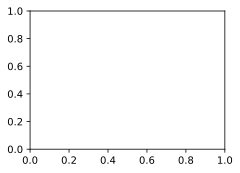

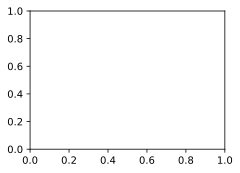

In [11]:
from trainer import ReinforceTrainer

optimizer = torch.optim.Adam(params = policy.parameters(), lr = 0.01)
trainer = ReinforceTrainer(policy, env, optimizer)

Episode 1000	Average Score: 165.60


[70,
 70,
 110,
 55,
 85,
 105,
 115,
 80,
 140,
 55,
 75,
 115,
 55,
 100,
 110,
 105,
 110,
 100,
 105,
 70,
 75,
 80,
 110,
 -15,
 105,
 35,
 50,
 90,
 80,
 45,
 65,
 70,
 50,
 90,
 75,
 75,
 55,
 65,
 70,
 70,
 125,
 105,
 -10,
 55,
 35,
 70,
 120,
 90,
 80,
 45,
 80,
 90,
 85,
 80,
 125,
 90,
 125,
 90,
 90,
 80,
 60,
 60,
 45,
 85,
 55,
 85,
 75,
 100,
 140,
 95,
 75,
 105,
 135,
 85,
 120,
 115,
 70,
 50,
 135,
 40,
 65,
 140,
 105,
 140,
 115,
 85,
 75,
 165,
 65,
 85,
 105,
 105,
 30,
 85,
 80,
 80,
 135,
 120,
 85,
 140,
 155,
 105,
 130,
 105,
 155,
 110,
 70,
 155,
 125,
 65,
 65,
 95,
 165,
 80,
 185,
 140,
 135,
 170,
 135,
 115,
 165,
 145,
 185,
 135,
 135,
 20,
 90,
 145,
 150,
 85,
 115,
 145,
 150,
 130,
 170,
 165,
 80,
 145,
 200,
 90,
 110,
 185,
 160,
 120,
 145,
 110,
 145,
 185,
 200,
 130,
 150,
 170,
 110,
 185,
 100,
 130,
 115,
 90,
 145,
 155,
 100,
 145,
 200,
 145,
 130,
 145,
 110,
 165,
 95,
 185,
 145,
 115,
 75,
 145,
 170,
 105,
 185,
 125,
 90,
 18

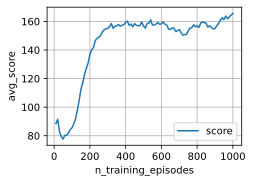

In [12]:
from trainer import reinforce

reinforce(policy, env, optimizer, 1000, 20, 1.0, 10)